## 1. 패키지 로딩하기

In [1]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 2. 포지셔널 행렬 만들기

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
                                     i        = tf.range(d_model,  dtype = tf.float32)[tf.newaxis, :],
                                     d_model  = d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines   = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis = -1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

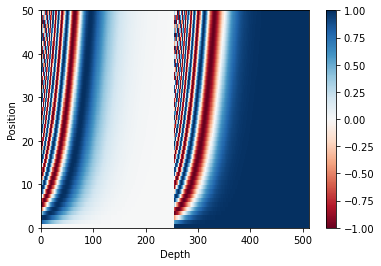

In [3]:
# 포지셔널 행렬 시각화하여 테스트해보기
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 3. 스케일드 닷 프로덕트 어텐션 함수 만들기

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산한다."""
    matmul_qk = tf.matmul(query, key, transpose_b = True)

    # scale matmul_qk
    depth  = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis = -1)

    output = tf.matmul(attention_weights, value)

    return output

## 4. 멀티 헤드 어텐션 함수 만들기
#### 내부적으로 스케일드 닷 프로덕트 어텐션 함수를 호출한다.

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name = "multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name = name)
        self.num_heads = num_heads
        self.d_model   = d_model
        
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units = d_model)
        self.key_dense   = tf.keras.layers.Dense(units = d_model)
        self.value_dense = tf.keras.layers.Dense(units = d_model)
        self.dense       = tf.keras.layers.Dense(units = d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape = (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm = [0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs["query"], inputs["key"], inputs["value"], inputs["mask"]
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key   = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만든다.
        query = self.split_heads(query, batch_size)
        key   = self.split_heads(key,   batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm = [0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)한다.
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## 5. 패딩 마스크(Padding Masking) 함수 만들기

In [6]:
# 패딩 마스크 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
# 잘 작동되는지 테스트 하기
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


## 6. 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기) 함수 만들기

In [8]:
# 룩 어헤드 마스킹 함수
def create_look_ahead_mask(x):
    seq_len         = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask    = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
# 잘 작동되는지 테스트 하기
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

# 룩 어헤드 마스킹과 패딩 마스킹은 별개이므로, 룩 어헤드 마스킹을 수행할 때 만약 숫자 0이 있다면 0도 패딩 해야 한다.
# 그래서 룩 어헤드 마스킹 함수에는 내부적으로 패딩 마스크 함수도 호출하고 있다.
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [10]:
# 두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수 만들기
# 인코더 하나의 레이어를 함수로 구현한다.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재한다.
def encoder_layer(units, d_model, num_heads, dropout, name = "encoder_layer"):
    inputs = tf.keras.Input(shape = (None, d_model),  name = "inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name = "attention")({
        "query": inputs,
        "key"  : inputs,
        "value": inputs,
        "mask" : padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization 이라는 훈련을 돕는 테크닉을 수행한다.
    attention = tf.keras.layers.Dropout(rate = dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units = units, activation = "relu")(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행한다.
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention + outputs)

    return tf.keras.Model(inputs = [inputs, padding_mask], outputs = outputs, name = name)

In [11]:
# 인코더 층을 쌓아서 인코더 만들기
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "encoder"):
    inputs = tf.keras.Input(shape = (None,), name = "inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)

    # num_layers 만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units     = units,
                                d_model   = d_model,
                                num_heads = num_heads,
                                dropout   = dropout,
                                name      = "encoder_layer_{}".format(i),
                               )([outputs, padding_mask])

    return tf.keras.Model(inputs = [inputs, padding_mask], outputs = outputs, name = name)

## 8. 디코더

In [12]:
# 세 개의 서브 층을 가지는 하나의 디코더 층을 구현한 함수 만들기
# 디코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재한다.
def decoder_layer(units, d_model, num_heads, dropout, name = "decoder_layer"):
    inputs          = tf.keras.Input(shape = (None, d_model), name = "inputs")
    enc_outputs     = tf.keras.Input(shape = (None, d_model), name = "encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape = (1, None, None), name = "look_ahead_mask")
    padding_mask    = tf.keras.Input(shape = (1, 1, None),    name = "padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name = "attention_1")(inputs = {
        "query": inputs,
        "key"  : inputs,
        "value": inputs,
        "mask" : look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행한다.
    attention1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name = "attention_2")(inputs = {
        "query": attention1,
        "key"  : enc_outputs,
        "value": enc_outputs,
        "mask" : padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행한다.
    attention2 = tf.keras.layers.Dropout(rate = dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units = units, activation = "relu")(attention2)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행한다.
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(outputs + attention2)

    return tf.keras.Model(inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask], outputs = outputs, name = name)

In [13]:
# 디코더 층을 쌓아 디코더 만들기
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "decoder"):
    inputs          = tf.keras.Input(shape = (None,),         name = "inputs")
    enc_outputs     = tf.keras.Input(shape = (None, d_model), name = "encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape = (1, None, None), name = "look_ahead_mask")

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행한다.
    outputs = tf.keras.layers.Dropout(rate = dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(units     = units,
                                d_model   = d_model,
                                num_heads = num_heads,
                                dropout   = dropout,
                                name      = "decoder_layer_{}".format(i),
                               )(inputs = [outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask], outputs = outputs, name = name)

## 9. 데이터 불러오기

In [14]:
# 데이터 전처리 함수 만들기
# 여기서는 정규 표현식을 이용하여 구두점을 제거하여 단어를 토크나이징할 때 방해가 되지 않도록 정제하는 것이 목표이다.
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuatuin) 사이의 거리를 만든다.
    # 예를 들어 "나는 학생입니다." -> "나는 학생입니다 ." 같이
    # student와 온점 사이에 거리를 만든다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, 가-힣, 숫자, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 " "로 대체한다.
    sentence = re.sub(r"[^a-zA-Z가-힣\d?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [15]:
# 데이터를 로드하는 동시에 전처리 함수를 사용하여 질문과 답변의 쌍으로 전처리한다.
def load_conversations():
    with open(path_to_dataset, "r") as file:
        lines = file.readlines()
        
    id2line = []
    for line in lines:
        parts  = line.replace("\n", "").split(",")
        id2line.append(parts)
    
    inputs, outputs = [], []
    for i in range(len(id2line) - 1):
        inputs.append(preprocess_sentence(id2line[1:][i][0]))
        outputs.append(preprocess_sentence(id2line[1:][i][1]))
    
    return inputs, outputs

In [16]:
path_to_dataset = tf.keras.utils.get_file(fname  = "ChatbotData.csv",
                                          origin = "https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv")

In [17]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print("전체 샘플 수 :", len(questions))
print("전체 샘플 수 :", len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


## 10. 병렬 데이터 전처리하기

### 10_1. 단어장(Vocabulary) 만들기

In [18]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size = 2 ** 13)

In [19]:
# 디코더의 문장 생성 과정에서 사용할 시작 토큰과 종료 토큰을 단어장에 추가하여서 정수를 부여해 준다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 토큰이 잘 생성됬는지 테스트 하기
print("START_TOKEN의 번호 :", [tokenizer.vocab_size])
print("END_TOKEN의 번호 :",   [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8139]
END_TOKEN의 번호 : [8140]


In [20]:
# 생성한 토큰을 고려하여 단어장 크기 설정하기
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8141


### 10_2. 각 단어를 고유한 정수로 인코딩(Integer encoding) 및 패딩(Padding) 하기

In [21]:
# 임의의 1번째 샘플에 대해서 정수 인코딩 작업을 수행한다.
# 각 토큰을 고유한 정수로 변환한다.
print("정수 인코딩 후의 1번째 질문 샘플: {}".format(tokenizer.encode(questions[0])))
print("정수 인코딩 후의 1번째 답변 샘플: {}".format(tokenizer.encode(answers[0])))

정수 인코딩 후의 1번째 질문 샘플: [7879, 4179, 3036, 40]
정수 인코딩 후의 1번째 답변 샘플: [3816, 75, 7858, 1]


In [22]:
# 패딩할 때 필요한 문장 최대 길이 설정하기
MAX_LENGTH = 40

In [23]:
# 인코딩과 패딩을 하는 함수 만들기
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가한다.
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩한다.
    tokenized_inputs  = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs,  maxlen = MAX_LENGTH, padding = "post")
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen = MAX_LENGTH, padding = "post")

    return tokenized_inputs, tokenized_outputs

In [24]:
# 만든 함수를 이용하여 인코딩과 패딩하기
questions, answers = tokenize_and_filter(questions, answers)

print("단어장의 크기 :", (VOCAB_SIZE))
print("필터링 후의 질문 샘플 개수 : {}".format(len(questions)))
print("필터링 후의 답변 샘플 개수 : {}".format(len(answers)))

단어장의 크기 : 8141
필터링 후의 질문 샘플 개수 : 11823
필터링 후의 답변 샘플 개수 : 11823


## 10_3. 교사 강요(Teacher Forcing) 사용하기

In [25]:
BATCH_SIZE  = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용한다.
# 이에 따라 outputs에서는 START_TOKEN을 제거한다.
dataset = tf.data.Dataset.from_tensor_slices(({"inputs" : questions, "dec_inputs" : answers[:, :-1]}, {"outputs" : answers[:, 1:]},))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 11. 모델 정의 및 학습하기

In [26]:
# 앞서서 만든 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의한다.
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "transformer"):
    inputs     = tf.keras.Input(shape = (None,), name = "inputs")
    dec_inputs = tf.keras.Input(shape = (None,), name = "dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape = (1, 1, None), name = "enc_padding_mask")(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용한다.
    # 내부적으로 패딩 마스크도 포함되어 있다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape = (1, None, None), name = "look_ahead_mask")(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹한다.
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape = (1, 1, None), name = "dec_padding_mask")(inputs)

    # 인코더
    enc_outputs = encoder(vocab_size = vocab_size, 
                          num_layers = num_layers, 
                          units      = units, 
                          d_model    = d_model, 
                          num_heads  = num_heads,
                          dropout    = dropout,)(inputs = [inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(vocab_size = vocab_size,
                          num_layers = num_layers,
                          units      = units,
                          d_model    = d_model,
                          num_heads  = num_heads,
                          dropout    = dropout,)(inputs = [dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units = vocab_size, name = "outputs")(dec_outputs)

    return tf.keras.Model(inputs = [inputs, dec_inputs], outputs = outputs, name = name)

### 11_1. 모델 생성하기

In [27]:
tf.keras.backend.clear_session() # 최근의 만든 모델이 있다면 지워준다.

# 하이퍼 파라미터
NUM_LAYERS = 6                   # 인코더와 디코더의 층의 개수
D_MODEL    = 512                 # 인코더와 디코더 내부의 입력, 출력의 고정 차원
NUM_HEADS  = 8                   # 멀티 헤드 어텐션에서의 헤드 수 
UNITS      = 512                 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT    = 0.1                 # dropout의 비율

model = transformer(vocab_size = VOCAB_SIZE,
                    num_layers = NUM_LAYERS,
                    units      = UNITS,
                    d_model    = D_MODEL,
                    num_heads  = NUM_HEADS,
                    dropout    = DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 512)    13636096    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 11_2. 손실 함수(Loss function)

In [28]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape = (-1, MAX_LENGTH - 1))
    loss   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = "none")(y_true, y_pred)
    mask   = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss   = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 11_3. 커스텀된 학습률(Learning rate)

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        self.d_model      = d_model
        self.d_model      = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

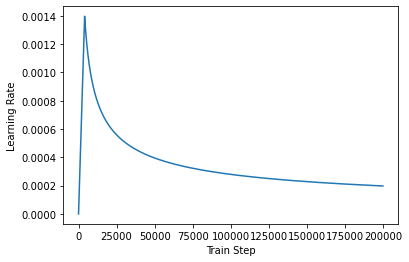

In [30]:
# 커스텀된 학습률 시각화 해보기
temp_learning_rate = CustomSchedule(d_model = 128)

plt.plot(temp_learning_rate(tf.range(200000, dtype = tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 11_4. 모델 컴파일 하기

In [31]:
learning_rate = CustomSchedule(D_MODEL)
optimizer     = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape = (-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer = optimizer, loss = loss_function, metrics = [accuracy])

### 11_5. 모델 훈련하기

In [32]:
EPOCHS = 400 # 훈련량 정하기
model.fit(dataset, epochs = EPOCHS, verbose = 1)

Epoch 1/400
185/185 [==============================] - 38s 206ms/step - loss: 1.3446 - accuracy: 0.0230
Epoch 2/400
185/185 [==============================] - 36s 194ms/step - loss: 1.0713 - accuracy: 0.0492
Epoch 3/400
185/185 [==============================] - 36s 195ms/step - loss: 0.9809 - accuracy: 0.0503
Epoch 4/400
185/185 [==============================] - 36s 195ms/step - loss: 0.9362 - accuracy: 0.0524
Epoch 5/400
185/185 [==============================] - 36s 195ms/step - loss: 0.9015 - accuracy: 0.0546
Epoch 6/400
185/185 [==============================] - 36s 196ms/step - loss: 0.8651 - accuracy: 0.0565
Epoch 7/400
185/185 [==============================] - 36s 196ms/step - loss: 0.8251 - accuracy: 0.0592
Epoch 8/400
185/185 [==============================] - 36s 196ms/step - loss: 0.7776 - accuracy: 0.0618
Epoch 9/400
185/185 [==============================] - 36s 196ms/step - loss: 0.7253 - accuracy: 0.0658
Epoch 10/400
185/185 [==============================] - 36s 197m

185/185 [==============================] - 35s 191ms/step - loss: 0.0610 - accuracy: 0.1574
Epoch 80/400
185/185 [==============================] - 35s 191ms/step - loss: 0.0590 - accuracy: 0.1576
Epoch 81/400
185/185 [==============================] - 35s 191ms/step - loss: 0.0584 - accuracy: 0.1579
Epoch 82/400
185/185 [==============================] - 35s 191ms/step - loss: 0.0579 - accuracy: 0.1579
Epoch 83/400
185/185 [==============================] - 35s 192ms/step - loss: 0.0584 - accuracy: 0.1578
Epoch 84/400
185/185 [==============================] - 35s 192ms/step - loss: 0.0551 - accuracy: 0.1588
Epoch 85/400
185/185 [==============================] - 35s 192ms/step - loss: 0.0556 - accuracy: 0.1585
Epoch 86/400
185/185 [==============================] - 35s 192ms/step - loss: 0.0548 - accuracy: 0.1585
Epoch 87/400
185/185 [==============================] - 35s 192ms/step - loss: 0.0532 - accuracy: 0.1592
Epoch 88/400
185/185 [==============================] - 35s 191ms/st

185/185 [==============================] - 35s 191ms/step - loss: 0.0228 - accuracy: 0.1674
Epoch 157/400
185/185 [==============================] - 35s 191ms/step - loss: 0.0224 - accuracy: 0.1676
Epoch 158/400
185/185 [==============================] - 35s 191ms/step - loss: 0.0232 - accuracy: 0.1672
Epoch 159/400
185/185 [==============================] - 35s 192ms/step - loss: 0.0221 - accuracy: 0.1675
Epoch 160/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0220 - accuracy: 0.1676
Epoch 161/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0217 - accuracy: 0.1676
Epoch 162/400
185/185 [==============================] - 36s 196ms/step - loss: 0.0219 - accuracy: 0.1675
Epoch 163/400
185/185 [==============================] - 38s 208ms/step - loss: 0.0213 - accuracy: 0.1678
Epoch 164/400
185/185 [==============================] - 41s 221ms/step - loss: 0.0213 - accuracy: 0.1679
Epoch 165/400
185/185 [==============================] - 41s

185/185 [==============================] - 36s 194ms/step - loss: 0.0119 - accuracy: 0.1706
Epoch 234/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0123 - accuracy: 0.1705
Epoch 235/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0126 - accuracy: 0.1703
Epoch 236/400
185/185 [==============================] - 36s 192ms/step - loss: 0.0127 - accuracy: 0.1703
Epoch 237/400
185/185 [==============================] - 36s 192ms/step - loss: 0.0119 - accuracy: 0.1706
Epoch 238/400
185/185 [==============================] - 37s 198ms/step - loss: 0.0121 - accuracy: 0.1705
Epoch 239/400
185/185 [==============================] - 36s 195ms/step - loss: 0.0115 - accuracy: 0.1706
Epoch 240/400
185/185 [==============================] - 36s 196ms/step - loss: 0.0118 - accuracy: 0.1706
Epoch 241/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0113 - accuracy: 0.1707
Epoch 242/400
185/185 [==============================] - 37s

185/185 [==============================] - 36s 193ms/step - loss: 0.0080 - accuracy: 0.1717
Epoch 311/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0082 - accuracy: 0.1716
Epoch 312/400
185/185 [==============================] - 36s 195ms/step - loss: 0.0079 - accuracy: 0.1716
Epoch 313/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0082 - accuracy: 0.1716
Epoch 314/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0080 - accuracy: 0.1717
Epoch 315/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0076 - accuracy: 0.1718
Epoch 316/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0079 - accuracy: 0.1718
Epoch 317/400
185/185 [==============================] - 36s 193ms/step - loss: 0.0075 - accuracy: 0.1718
Epoch 318/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0079 - accuracy: 0.1718
Epoch 319/400
185/185 [==============================] - 36s

185/185 [==============================] - 36s 194ms/step - loss: 0.0059 - accuracy: 0.1724
Epoch 388/400
185/185 [==============================] - 36s 195ms/step - loss: 0.0053 - accuracy: 0.1725
Epoch 389/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0058 - accuracy: 0.1724
Epoch 390/400
185/185 [==============================] - 36s 195ms/step - loss: 0.0054 - accuracy: 0.1724
Epoch 391/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0058 - accuracy: 0.1723
Epoch 392/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0054 - accuracy: 0.1725
Epoch 393/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0054 - accuracy: 0.1724
Epoch 394/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0059 - accuracy: 0.1724
Epoch 395/400
185/185 [==============================] - 36s 194ms/step - loss: 0.0054 - accuracy: 0.1724
Epoch 396/400
185/185 [==============================] - 36s

## 12. 모델 테스트하기
#### 예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.
* 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
* 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
* 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
* 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
* 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
* END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [33]:
# 위에서 말한 과정을 수행하는 함수 만들기
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)
    
    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가한다.
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis = 0)
    
    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복한다.
        predictions = model(inputs = [sentence, output_sequence], training = False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)
        
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료한다.
        if tf.equal(predicted_id, END_TOKEN[0]): break
        
        # 예측한 단어들은 지속적으로 output_sequence에 추가된다.
        # 이 output_sequence는 다시 디코더의 입력이 된다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis = -1)
        
    return tf.squeeze(output_sequence, axis = 0)

In [34]:
# 임의의 입력 문장에 대해서 위에 만든 함수를 호출하여 챗봇의 대답을 얻는 함수 만들기
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 작동시켜 예측된 정수 시퀀스를 반환한다.
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환한다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print("입력 : {}".format(sentence))
    print("출력 : {}".format(predicted_sentence))
    
    return predicted_sentence

In [35]:
sentence_generation("퇴근이 가능할까?")

입력 : 퇴근이 가능할까?
출력 : 뭘 잘못 먹었나봐요 .


'뭘 잘못 먹었나봐요 .'

In [36]:
sentence_generation("저녁을 먹어도 될까?")

입력 : 저녁을 먹어도 될까?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [37]:
sentence_generation("공부하기 싫어")

입력 : 공부하기 싫어
출력 : 잠시 쉬어도 돼요 .


'잠시 쉬어도 돼요 .'

In [38]:
sentence_generation("자기소개 해봐")

입력 : 자기소개 해봐
출력 : 강렬하고 자신감있게 하면 되지 않을까싶어요 .


'강렬하고 자신감있게 하면 되지 않을까싶어요 .'

In [39]:
sentence_generation("나 머리 아파")

입력 : 나 머리 아파
출력 : 시원한 바람 쉬고 약먹기 !


'시원한 바람 쉬고 약먹기 !'

In [40]:
sentence_generation("사람은 왜 살아?")

입력 : 사람은 왜 살아?
출력 : 서로 마음이 같지 않았나봐요 .


'서로 마음이 같지 않았나봐요 .'

In [41]:
sentence_generation("위스키 한잔 할래?")

입력 : 위스키 한잔 할래?
출력 : 즐거운 시작 되길 바랍니다 .


'즐거운 시작 되길 바랍니다 .'

## 회고록

In [ ]:
# 이번 노드는 개념부터 코딩까지 전부 어려웠다. 전혀 쉬운부분이 없어서 쉬는 타임이 없었다.
# 그래서 더욱 힘들었다. 역대 2번쨰... 1번째는 리뷰 감성분석이다.
# 개념도 어려워서 2~3번 봤다.
# 노드를 보면서 코드를 타이핑 하는 편인데, 코드를 타이핑을 똑같이 했다고 생각했는데도 우리의 챗봇은 아무 대답이 없었다.
# 또한 한글 데이터의 전처리는 영어 데이터랑 달라서 코드를 수정하는데 애를 먹었다.
# 근데 막상 하다보니 '내가 너무 어렵게 하려 하고 있다' 라는 생각을 하게 되었고, '결국 결과만 같으면 되는 것 아닌가' 라는 생각을 해서 전처리를 했다.
# 그리고 코드는 결국 복사, 붙여넣기를 통해 했다. 내가 타이핑한 코드에서 어느 부분이 달라서 작동이 제대로 안 되는지 찾지 못했다.
# 그리고 20번 훈련을 시키니 대답을 너무 잘했다. "나 우울해" -> "밖에 나가서 기분을 전환해요"
# 그래서 저녁먹고 복습 겸 블로그 작성을 하는 동안 학습을 시켜보고 싶어서 400번을 훈련시켰다.
# 결과는 만족스럽다.